In [1]:
% pylab inline
import tensorflow as tf
import numpy as np
# import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.contrib.kfac.python.ops.utils import fwd_gradients
import seaborn as sns
from utils import nn_l2_mean
slim = tf.contrib.slim
ds = tf.contrib.distributions
from universal_divergence import estimate

import os
os.environ["CUDA_VISIBLE_DEVICES"]="6"

Populating the interactive namespace from numpy and matplotlib


In [2]:
tf.reset_default_graph()


### Generator and discriminator architectures

(same architecture as proposed in google brain paper)


In [3]:
def generator(z, output_dim=2, n_hidden=384, n_layer=6):
    with tf.variable_scope("generator"):
        h = slim.stack(z, slim.fully_connected, [n_hidden] * n_layer, activation_fn=tf.nn.relu)
        x = slim.fully_connected(h, output_dim, activation_fn=None)
    return x

def discriminator(x, n_hidden=384, n_layer=6, reuse=False):
    with tf.variable_scope("discriminator", reuse=reuse):
        h = slim.stack(x, slim.fully_connected, [n_hidden] * n_layer, activation_fn=tf.nn.relu)
        log_d = slim.fully_connected(h, 1, activation_fn=None)
    return log_d

### Data creation

In [4]:
def sample_mog(batch_size, n_mixture=16, std=0.2):
    x = np.linspace(-4.5,4.5,4)
    xs, ys = np.meshgrid(x, x)
    xs, ys = xs.flatten(), ys.flatten()
    cat = ds.Categorical(tf.zeros(n_mixture))
    comps = [ds.MultivariateNormalDiag([xi, yi], [std, std]) for xi, yi in zip(xs.ravel(), ys.ravel())]
    data = ds.Mixture(cat, comps)
    return data.sample(batch_size)

### Hyperparam

In [5]:
params = dict(
    batch_size=512,
    start_learning_rate=1e-3,
    beta1=0.5,
    epsilon=1e-8,
    max_iter=100000,
    viz_every=1000,
    z_dim=256,
    x_dim=2,
    optimizer='sgd', # rmsprop sgd sga
    lambd=1e-2
)

## Function for Symplectic gradient adjustment

## Construct model and training ops

In [6]:
tf.reset_default_graph()

data = sample_mog(params['batch_size'])
noise = ds.Normal(tf.zeros(params['z_dim']), tf.ones(params['z_dim'])).sample(params['batch_size'])
learning_rate = tf.placeholder(tf.float32, shape=(), name="lr_pl")

# Construct generator and discriminator nets
with slim.arg_scope([slim.fully_connected], weights_initializer=tf.orthogonal_initializer(gain=1.)):
    samples = generator(noise, output_dim=params['x_dim'])
    real_score = discriminator(data)
    fake_score = discriminator(samples, reuse=True)
    
# Saddle objective    
loss = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(logits=real_score, labels=tf.ones_like(real_score)) +
    tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_score, labels=tf.zeros_like(fake_score)))

gen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "generator")
disc_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "discriminator")

if params['optimizer'] == 'rmsprop':
    print('sgd')
    g_train_opt = tf.train.RMSPropOptimizer(learning_rate)
    d_train_opt = tf.train.RMSPropOptimizer(learning_rate)
    d_train_op = d_train_opt.minimize(loss, var_list=disc_vars)
    g_train_op = g_train_opt.minimize(-loss, var_list=gen_vars)
    train_op = tf.group(g_train_op, d_train_op)

elif params['optimizer'] == 'sgd':    
    d_train_opt = tf.train.GradientDescentOptimizer(learning_rate)
    g_train_opt = tf.train.GradientDescentOptimizer(learning_rate)
    d_train_op = d_train_opt.minimize(loss, var_list=disc_vars)
    g_train_op = g_train_opt.minimize(-loss, var_list=gen_vars)
    train_op = tf.group(d_train_op,g_train_op)

elif params['optimizer'] == 'georgios': 
    print('georgios')

#     optimizer = tf.train.GradientDescentOptimizer(params['disc_learning_rate'])
    d_grads = tf.gradients(loss, disc_vars)
    g_grads = tf.gradients(-loss, gen_vars)
    
    variables = disc_vars + gen_vars
    grads = d_grads + g_grads
    
    var_updates = []
    for grad, var in zip(grads, variables):
        var_updates.append(var.assign_sub(learning_rate * (grad - params['lambd'] * var)))
    train_op = tf.group(*var_updates)
    
#     apply_vec = [(g - params['lambd'] * v, v)for (g, v) in zip(grads, variables)]
    
#     with tf.control_dependencies([g for (g, v) in apply_vec]):
#         train_op = optimizer.apply_gradients(apply_vec)
    
# elif params['optimizer'] == 'consensus': 
#     print('consensus')
#     d_opt = tf.train.RMSPropOptimizer(learning_rate=params['disc_learning_rate'])
#     g_opt = tf.train.RMSPropOptimizer(learning_rate=params['gen_learning_rate'])
    
#     optimizer = tf.train.RMSPropOptimizer(params['disc_learning_rate'], use_locking=True)

    
# #     dvs = d_opt.compute_gradients(loss, var_list=disc_vars)
# #     gvs = g_opt.compute_gradients(-loss, var_list=gen_vars)
    
#     d_grads = tf.gradients(loss, disc_vars)
#     g_grads = tf.gradients(-loss, gen_vars)
    
#     variables = disc_vars + gen_vars
#     grads = d_grads + g_grads
    

#     # Reguliarizer
#     reg = 0.5 * sum(tf.reduce_sum(tf.square(g)) for g in grads)
#     # Jacobian times gradiant
#     Jgrads = tf.gradients(reg, variables)
    
#     apply_vec = [(g + params['reg_w'] * Jg, v)for (g, Jg, v) in zip(grads, Jgrads, variables) if Jg is not None]
    
#     with tf.control_dependencies([g for (g, v) in apply_vec]):
#         train_op = optimizer.apply_gradients(apply_vec)

## Train

In [7]:
# config = tf.ConfigProto(device_count={'GPU': 0})
# config.gpu_options.allow_growth = True
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

  0%|          | 0/100001 [00:00<?, ?it/s]

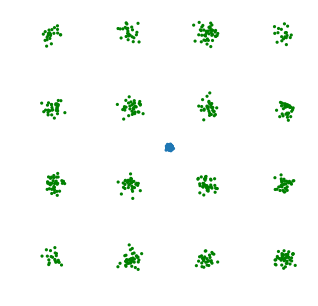

  1%|          | 992/100001 [00:12<18:52, 87.41it/s]  

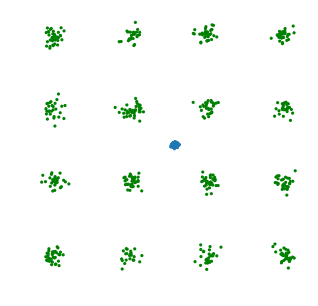

  2%|▏         | 2000/100001 [00:24<18:36, 87.78it/s]

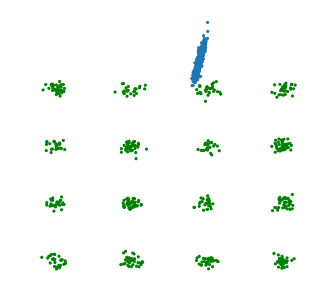

  3%|▎         | 2998/100001 [00:35<18:10, 88.97it/s]

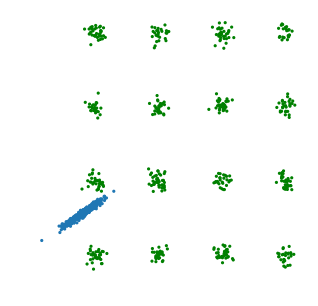

  4%|▍         | 3994/100001 [00:46<17:13, 92.89it/s]

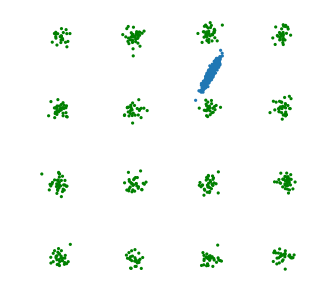

  5%|▍         | 4994/100001 [00:57<17:16, 91.65it/s]

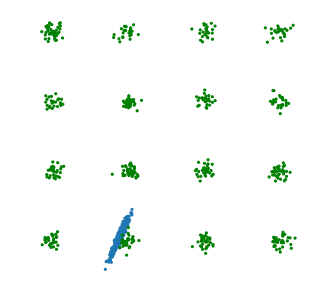

  6%|▌         | 5994/100001 [01:08<17:41, 88.56it/s]

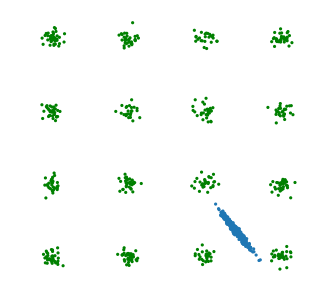

  7%|▋         | 6993/100001 [01:19<16:35, 93.40it/s]

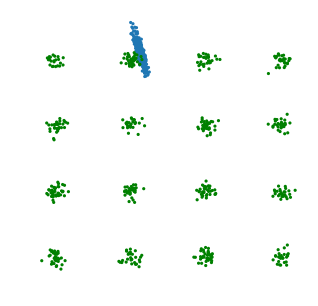

  8%|▊         | 7993/100001 [01:30<16:14, 94.37it/s]

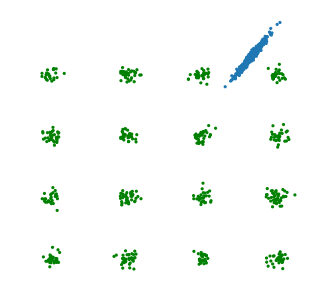

  9%|▉         | 8993/100001 [01:40<15:44, 96.34it/s]

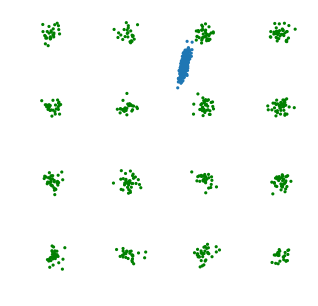

 10%|▉         | 9993/100001 [01:51<16:03, 93.39it/s]

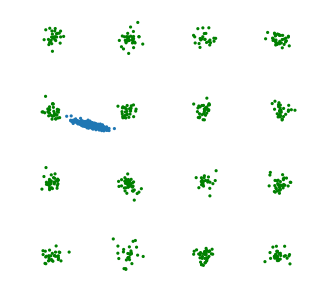

 11%|█         | 10993/100001 [02:02<15:31, 95.51it/s]

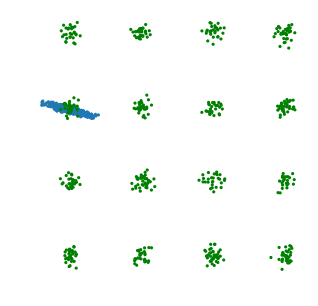

 12%|█▏        | 11993/100001 [02:12<15:25, 95.10it/s]

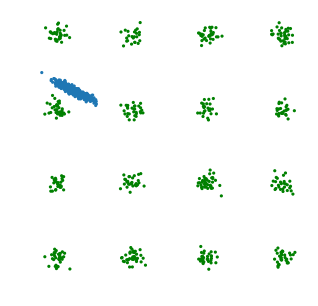

 13%|█▎        | 12992/100001 [02:23<15:22, 94.30it/s]

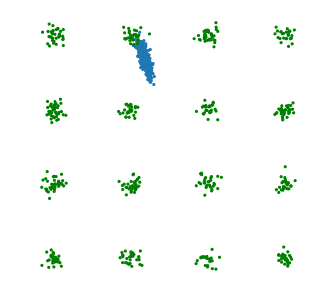

 14%|█▍        | 13992/100001 [02:34<15:14, 94.02it/s]

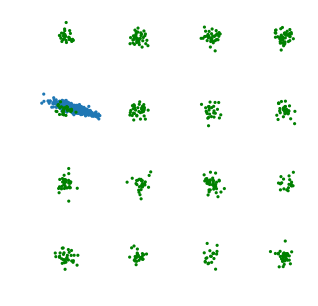

 15%|█▍        | 14993/100001 [02:44<14:10, 99.91it/s] 

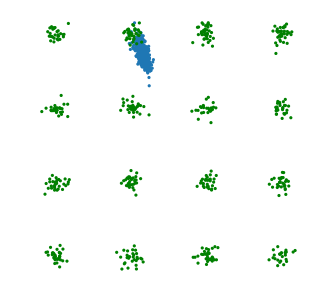

 16%|█▌        | 15999/100001 [02:54<14:02, 99.71it/s] 

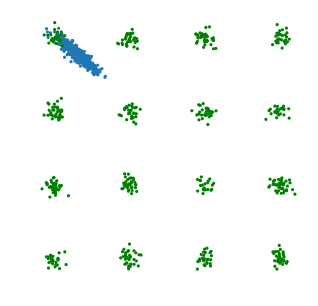

 17%|█▋        | 16994/100001 [03:04<14:32, 95.15it/s] 

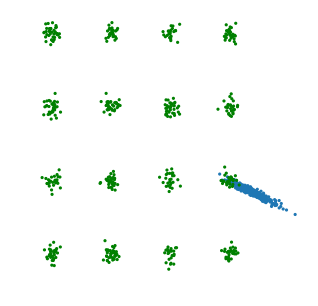

 18%|█▊        | 17994/100001 [03:15<14:02, 97.34it/s]

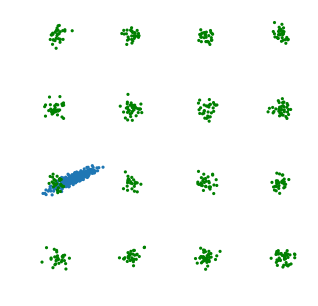

 19%|█▉        | 18995/100001 [03:26<14:12, 94.98it/s]

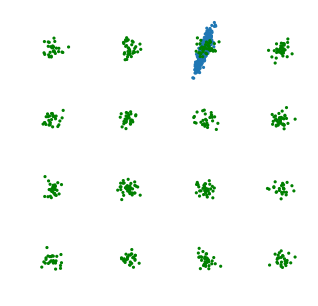

 20%|█▉        | 19995/100001 [03:36<13:50, 96.35it/s]

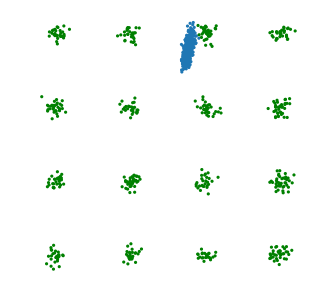

 21%|██        | 20995/100001 [03:47<13:34, 97.00it/s]

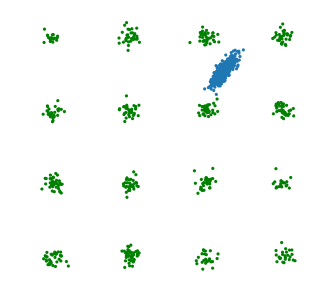

 22%|██▏       | 21999/100001 [03:57<13:19, 97.59it/s]

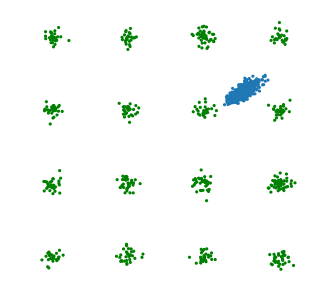

 23%|██▎       | 22992/100001 [04:07<13:02, 98.45it/s]

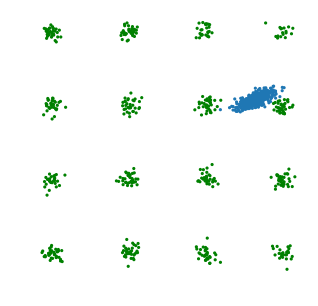

 24%|██▍       | 23998/100001 [04:18<13:13, 95.82it/s]

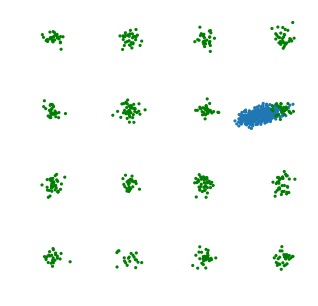

 25%|██▍       | 24992/100001 [04:28<12:46, 97.89it/s]

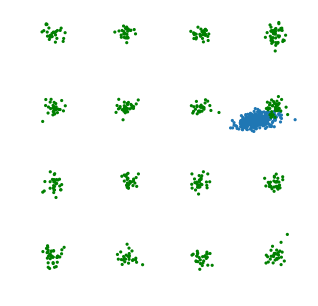

 26%|██▌       | 25997/100001 [04:39<12:44, 96.74it/s]

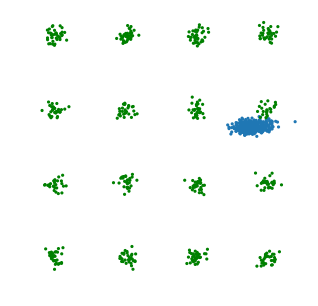

 27%|██▋       | 26997/100001 [04:49<12:38, 96.23it/s]

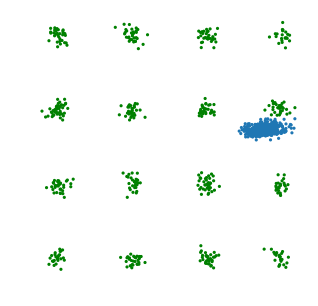

 28%|██▊       | 27997/100001 [05:00<12:38, 94.98it/s]

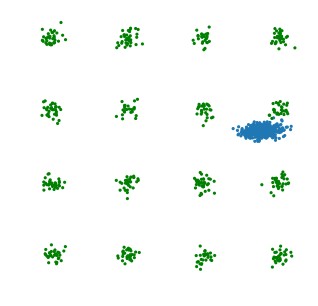

 29%|██▉       | 28999/100001 [05:11<12:16, 96.34it/s]

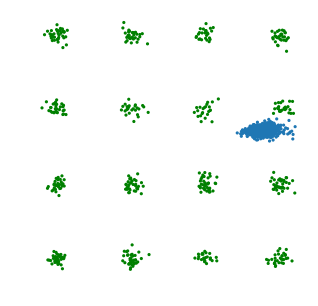

 30%|██▉       | 29991/100001 [05:21<12:00, 97.15it/s]

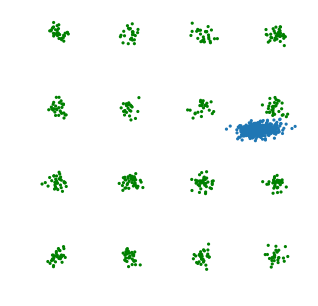

 31%|███       | 30991/100001 [05:32<11:56, 96.36it/s]

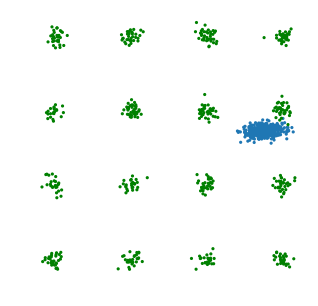

 32%|███▏      | 31991/100001 [05:42<11:53, 95.32it/s]

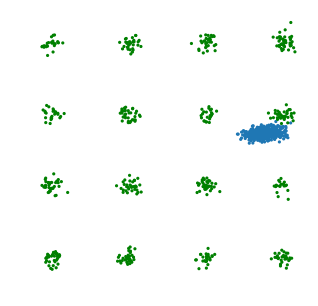

 33%|███▎      | 32991/100001 [05:53<11:43, 95.21it/s]

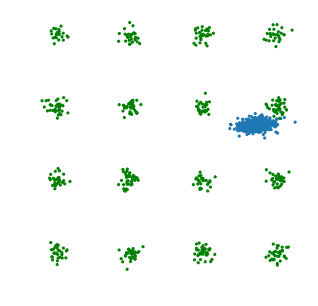

 34%|███▍      | 33991/100001 [06:03<11:32, 95.26it/s]

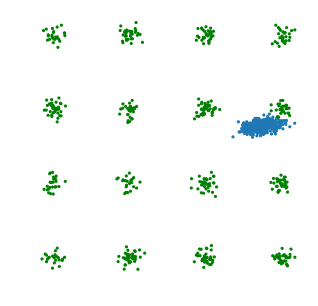

 35%|███▍      | 34991/100001 [06:14<11:24, 94.91it/s]

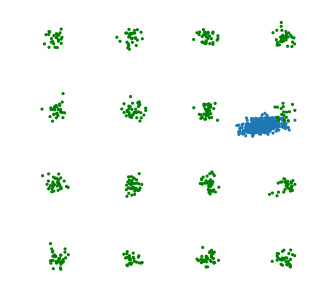

 36%|███▌      | 36000/100001 [06:25<11:10, 95.49it/s]

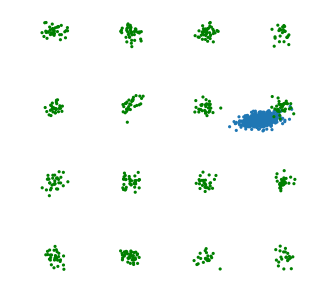

 37%|███▋      | 37000/100001 [06:35<11:05, 94.69it/s]

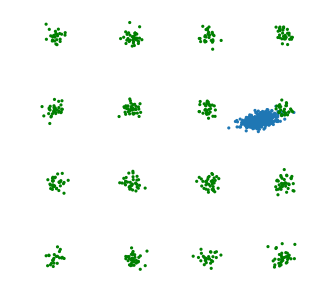

 38%|███▊      | 38000/100001 [06:46<11:00, 93.84it/s]

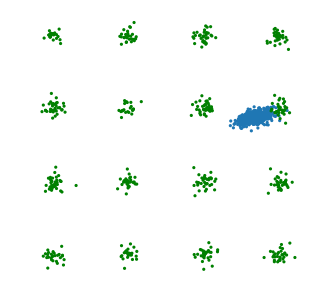

 39%|███▉      | 39000/100001 [06:57<10:41, 95.12it/s]

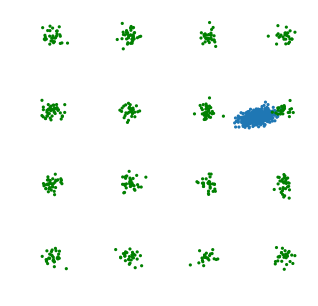

 40%|███▉      | 40000/100001 [07:07<10:31, 95.05it/s]

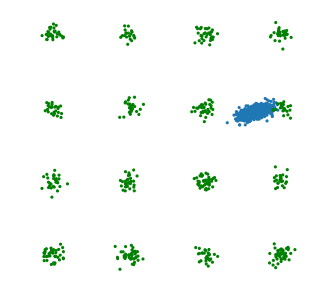

 41%|████      | 41000/100001 [07:18<10:38, 92.45it/s]

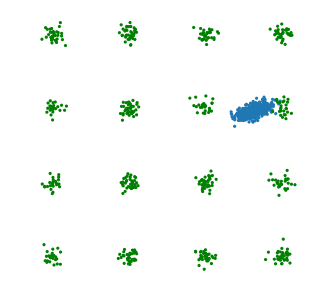

 42%|████▏     | 41997/100001 [07:29<10:36, 91.18it/s]

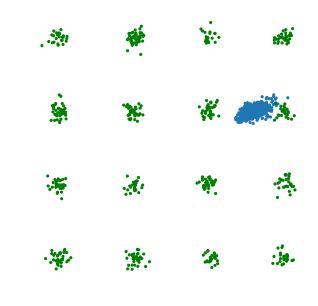

 43%|████▎     | 42996/100001 [07:40<10:23, 91.36it/s]

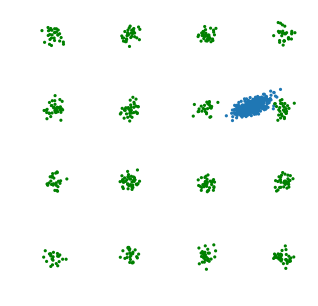

 44%|████▍     | 43991/100001 [07:51<10:15, 91.03it/s]

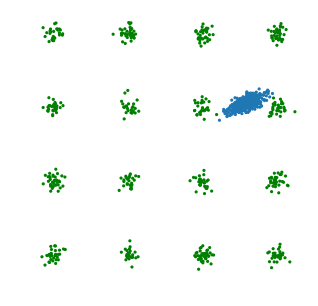

 45%|████▍     | 44992/100001 [08:03<10:15, 89.40it/s]

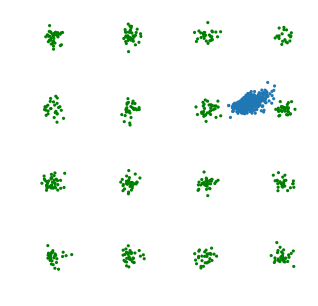

 46%|████▌     | 45993/100001 [08:14<10:18, 87.29it/s]

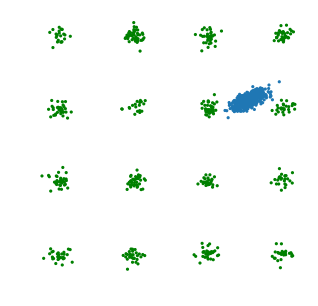

 47%|████▋     | 46995/100001 [08:26<10:12, 86.58it/s]

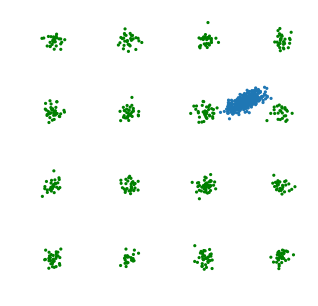

 48%|████▊     | 47999/100001 [08:37<09:49, 88.23it/s]

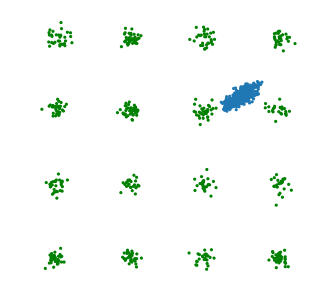

 49%|████▉     | 48993/100001 [08:49<09:50, 86.41it/s]

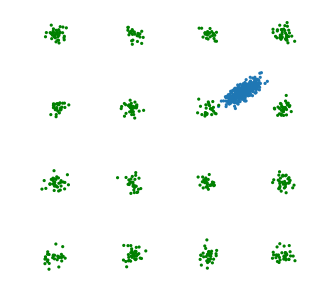

 50%|████▉     | 49992/100001 [09:00<09:23, 88.68it/s]

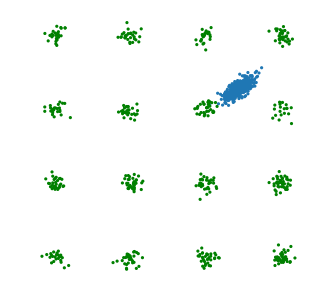

 51%|█████     | 50996/100001 [09:12<09:11, 88.79it/s]

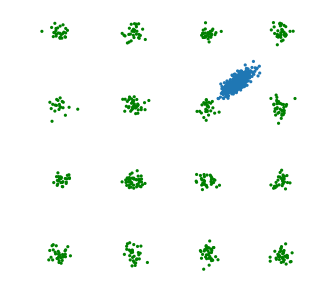

 52%|█████▏    | 51992/100001 [09:23<09:06, 87.82it/s]

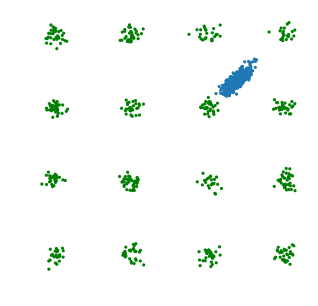

 53%|█████▎    | 52997/100001 [09:35<08:49, 88.80it/s]

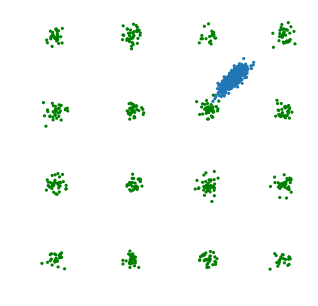

 54%|█████▍    | 53997/100001 [09:46<08:26, 90.83it/s]

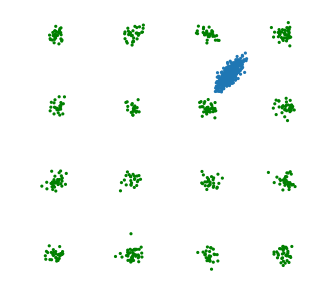

 55%|█████▍    | 55000/100001 [09:57<08:15, 90.79it/s]

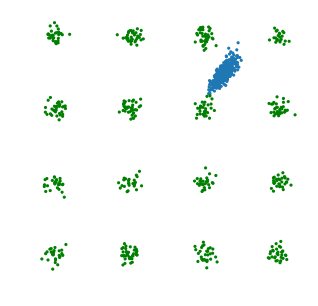

 56%|█████▌    | 55997/100001 [10:08<08:04, 90.78it/s]

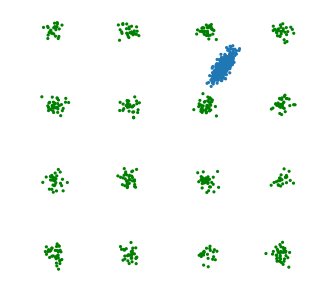

 57%|█████▋    | 56993/100001 [10:19<07:49, 91.52it/s]

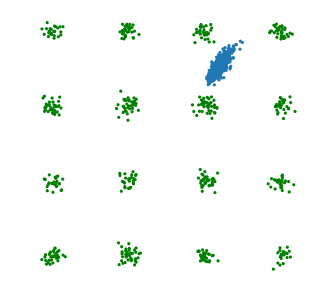

 58%|█████▊    | 57999/100001 [10:31<07:28, 93.60it/s]

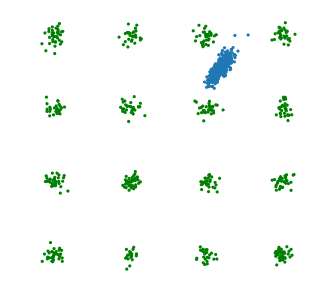

 59%|█████▉    | 58997/100001 [10:41<07:18, 93.53it/s]

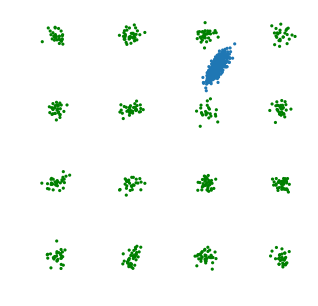

 60%|█████▉    | 59997/100001 [10:52<07:07, 93.59it/s]

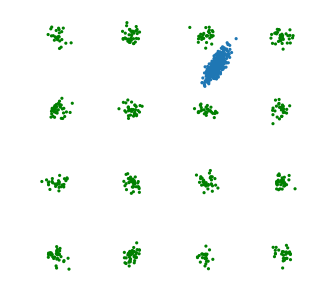

 61%|██████    | 60997/100001 [11:03<07:02, 92.36it/s]

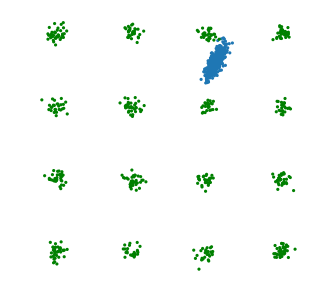

 62%|██████▏   | 61997/100001 [11:14<06:44, 93.90it/s]

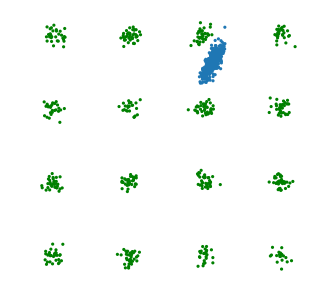

 63%|██████▎   | 62997/100001 [11:25<06:31, 94.63it/s]

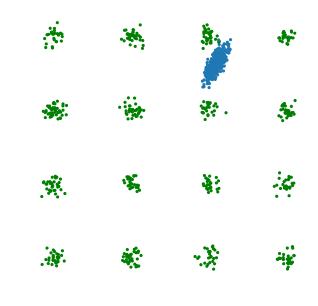

 64%|██████▍   | 63997/100001 [11:35<06:19, 94.87it/s]

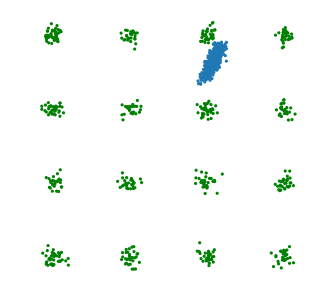

 65%|██████▍   | 64997/100001 [11:46<06:11, 94.17it/s]

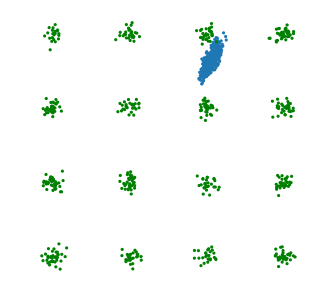

 66%|██████▌   | 65997/100001 [11:57<06:06, 92.90it/s]

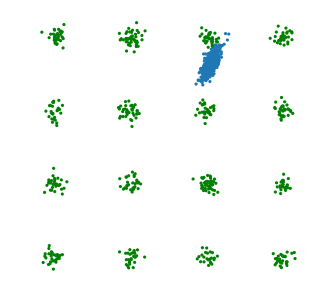

 67%|██████▋   | 66997/100001 [12:08<05:56, 92.64it/s]

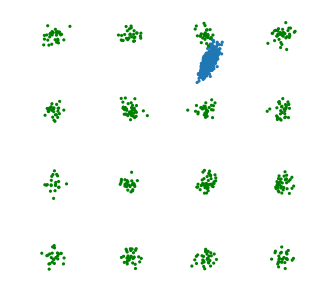

 68%|██████▊   | 67996/100001 [12:18<05:45, 92.70it/s]

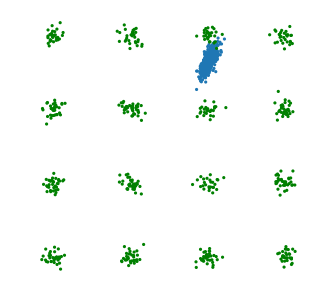

 69%|██████▉   | 68996/100001 [12:29<05:34, 92.69it/s]

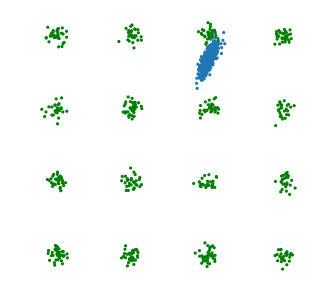

 70%|██████▉   | 69996/100001 [12:40<05:23, 92.76it/s]

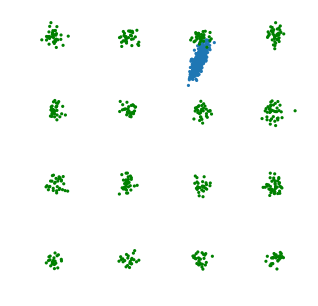

 71%|███████   | 70995/100001 [12:51<05:12, 92.96it/s]

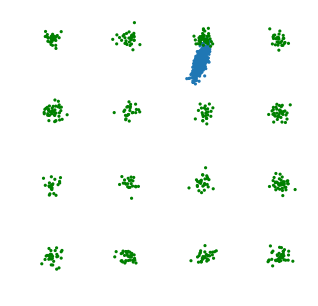

 72%|███████▏  | 71995/100001 [13:02<05:05, 91.58it/s]

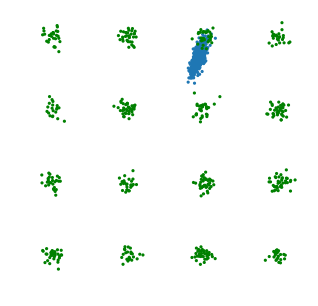

 73%|███████▎  | 72997/100001 [13:13<04:51, 92.60it/s]

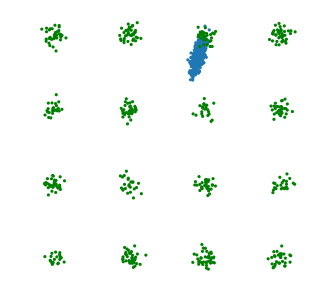

 74%|███████▍  | 73996/100001 [13:24<04:41, 92.54it/s]

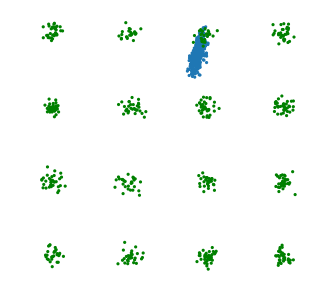

 75%|███████▍  | 74996/100001 [13:35<04:33, 91.39it/s]

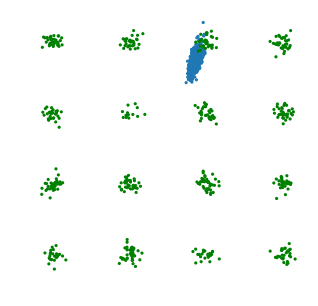

 76%|███████▌  | 75994/100001 [13:46<04:19, 92.36it/s]

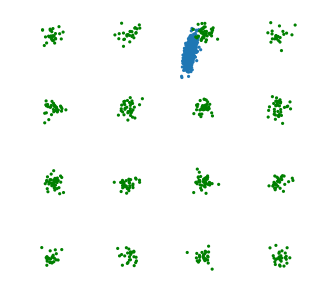

 77%|███████▋  | 76993/100001 [13:57<04:24, 86.86it/s]

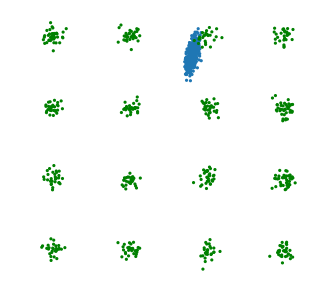

 78%|███████▊  | 77992/100001 [14:09<04:12, 87.18it/s]

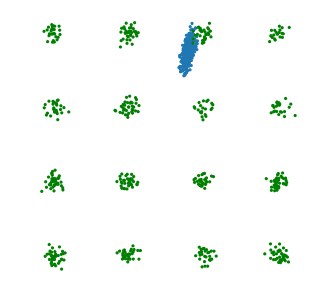

 79%|███████▉  | 79000/100001 [14:21<04:00, 87.17it/s]

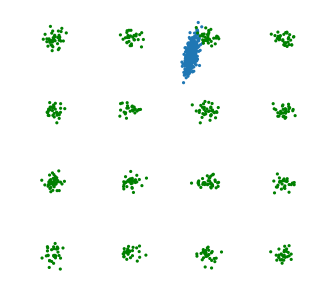

 80%|███████▉  | 79998/100001 [14:33<04:04, 81.87it/s]

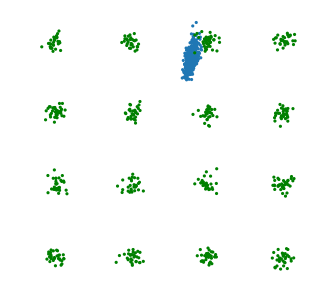

 81%|████████  | 80998/100001 [14:45<03:44, 84.65it/s]

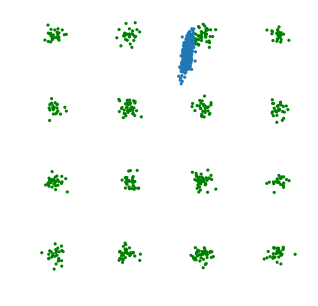

 82%|████████▏ | 81997/100001 [14:57<03:38, 82.41it/s]

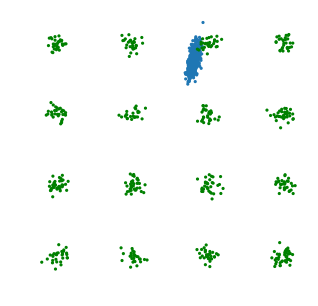

 83%|████████▎ | 82996/100001 [15:10<03:28, 81.68it/s]

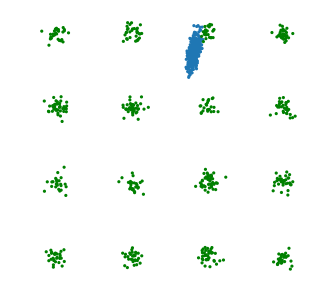

 84%|████████▍ | 83997/100001 [15:22<03:19, 80.12it/s]

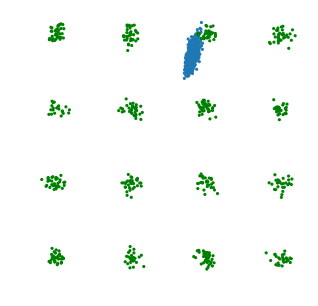

 85%|████████▍ | 84998/100001 [15:35<02:58, 83.97it/s]

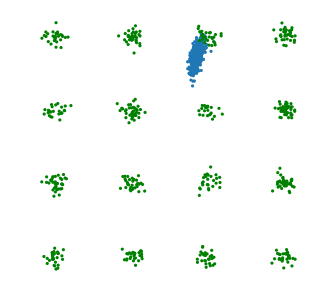

 86%|████████▌ | 85994/100001 [15:48<03:12, 72.74it/s]

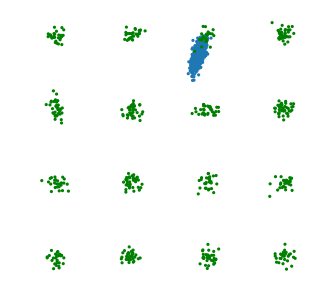

 87%|████████▋ | 86998/100001 [16:03<03:31, 61.62it/s]

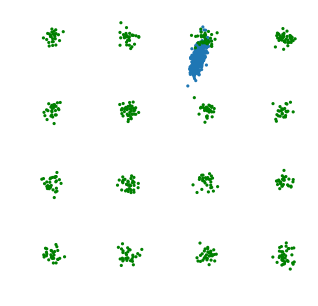

 88%|████████▊ | 87999/100001 [16:20<03:12, 62.33it/s]

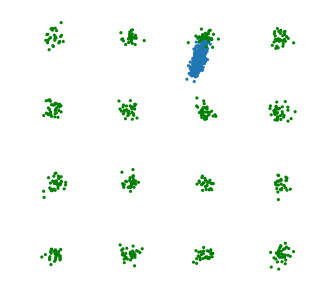

 89%|████████▉ | 89000/100001 [16:39<03:32, 51.87it/s]

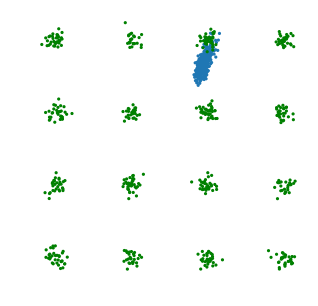

 90%|████████▉ | 89997/100001 [16:56<02:44, 60.69it/s]

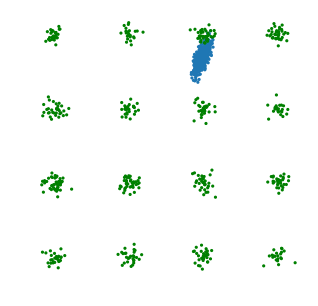

 91%|█████████ | 90998/100001 [17:13<02:11, 68.65it/s]

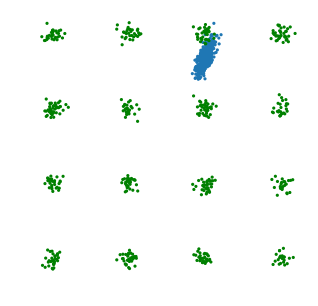

 92%|█████████▏| 91995/100001 [17:29<02:00, 66.30it/s]

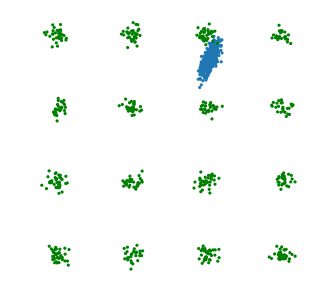

 93%|█████████▎| 92999/100001 [17:44<01:21, 85.62it/s]

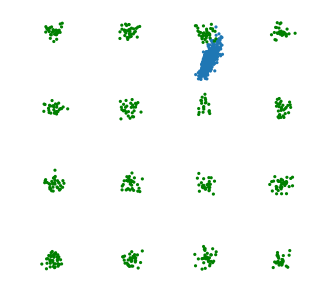

 94%|█████████▍| 93994/100001 [17:56<01:12, 83.24it/s]

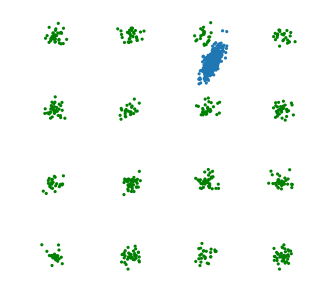

 95%|█████████▍| 94995/100001 [18:08<01:00, 82.38it/s]

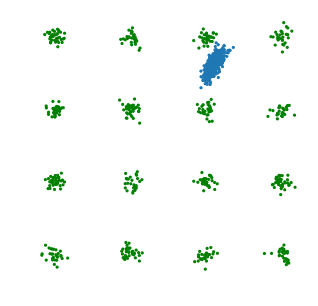

 96%|█████████▌| 96000/100001 [18:22<00:47, 84.05it/s]

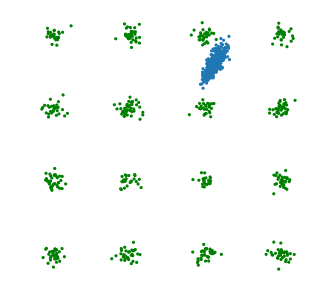

 97%|█████████▋| 97000/100001 [18:35<00:43, 68.67it/s]

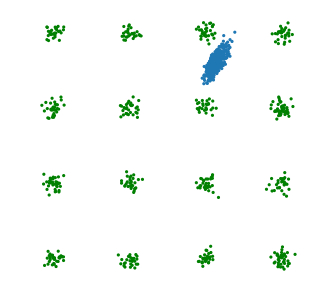

 98%|█████████▊| 97994/100001 [18:48<00:23, 85.24it/s]

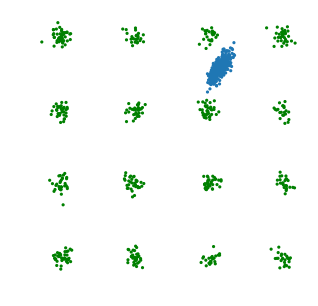

 99%|█████████▉| 98996/100001 [19:00<00:12, 79.97it/s]

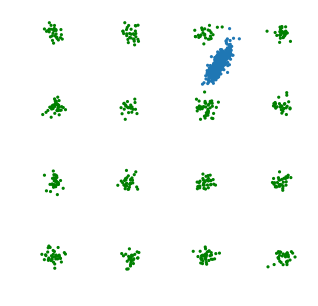

100%|█████████▉| 99992/100001 [19:12<00:00, 86.18it/s]

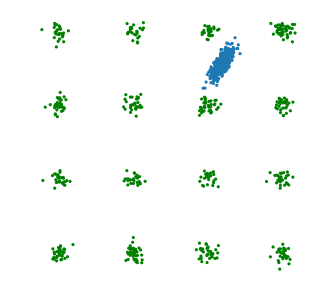

100%|██████████| 100001/100001 [19:13<00:00, 63.56it/s]


In [8]:
xmax = 3
fs = []
frames = []
np_samples = []
n_batches_viz = 10
viz_every = params['viz_every']
nn_every = 200
y_ref = sess.run( data)
nn_dist = []
nn_kl =[]
step_lr = 1
for i in tqdm(range(params['max_iter']+1)):
#     f, _, _ = sess.run([[loss], g_train_op, d_train_op])
    if i > 20000:
        feed_dict = {learning_rate: params['start_learning_rate']/np.sqrt(step_lr)}
        f, _= sess.run([[loss], train_op], feed_dict=feed_dict)
        step_lr += 1
    else:
        feed_dict = {learning_rate: params['start_learning_rate']}
        f, _= sess.run([[loss], train_op], feed_dict=feed_dict)
        

    fs.append(f)
    if (i) % viz_every == 0:
        np_samples.append(np.vstack([sess.run(samples) for _ in range(n_batches_viz)]))
        xx, yy = sess.run([samples, data])
        fig = figure(figsize=(5,5))
        scatter(xx[:, 0], xx[:, 1], edgecolor='none',s=10)
        scatter(yy[:, 0], yy[:, 1], c='g', edgecolor='none',s=10)
#         plt.xlim([-5.5, 5.5])
#         plt.ylim([-5.5, 5.5])
        axis('off')
        show()
        
#     if (i) % nn_every == 0:
#         x = np.vstack([sess.run(samples) for _ in range(n_batches_viz)])
#         l2nn = nn_l2_mean(x,y_ref)
#         kl =estimate(x, y_ref,k=1)
#         nn_dist.append(l2nn)
#         nn_kl.append(kl)
#         print('dist = ', l2nn)
#         print('kl = ', kl)

    

In [9]:
# np_samples_ = np_samples[::1]
# cols = len(np_samples_)
# bg_color  = sns.color_palette('Greens', n_colors=256)[0]
# figure(figsize=(2*cols, 2))
# for i, samps in enumerate(np_samples_):
#     if i == 0:
#         ax = subplot(1,cols,1)
#     else:
#         subplot(1,cols,i+1, sharex=ax, sharey=ax)
# #     ax2 = sns.kdeplot(samps[:, 0], samps[:, 1], shade=True, cmap='Greens', n_levels=20, clip=[[-6,6]]*2)
#     ax2 = sns.kdeplot(samps[:, 0], samps[:, 1], shade=True, cmap='coolwarm',bw=.40, n_levels=20, clip=[[-6,6]]*2)

# #     ax2.set_axis_bgcolor(bg_color)
#     xticks([]); yticks([])
#     title('step %d'%(i*viz_every))
# gcf().tight_layout()

In [10]:
# plt.semilogy(nn_dist)
# plt.semilogy(nn_kl)
# plt.legend(['kl','l2 nearest neigbhors'])
# xlabel('iterations')
# plt.show()

In [11]:
# np.save('plot_con_kl',nn_kl)
# np.save('plot_con_nn',nn_dist)